## Time series forecasting (ARIMA)
Specific building Eagle_Health Vincenza, on Steam usage

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='C:/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
STEAM_FILE='steam.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed

In [4]:
steam_df = read_zip_to_panda(ZIP_PATH,STEAM_FILE)
steam_df = fix_date_type(steam_df)
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 370 entries, Peacock_lodging_Terrie to Cockatoo_public_Shad
dtypes: float64(370)
memory usage: 49.7 MB


In [5]:
steam_df = steam_df['Eagle_health_Vincenza'] #['1-1-2016':'12-31-2016']
building = steam_df
#building = building.replace( 0,  4)
steam_df.describe()

count    17487.000000
mean       122.346821
std         63.734555
min          0.000000
25%         75.201850
50%        120.122000
75%        165.704400
max        339.630000
Name: Eagle_health_Vincenza, dtype: float64

<AxesSubplot:xlabel='timestamp'>

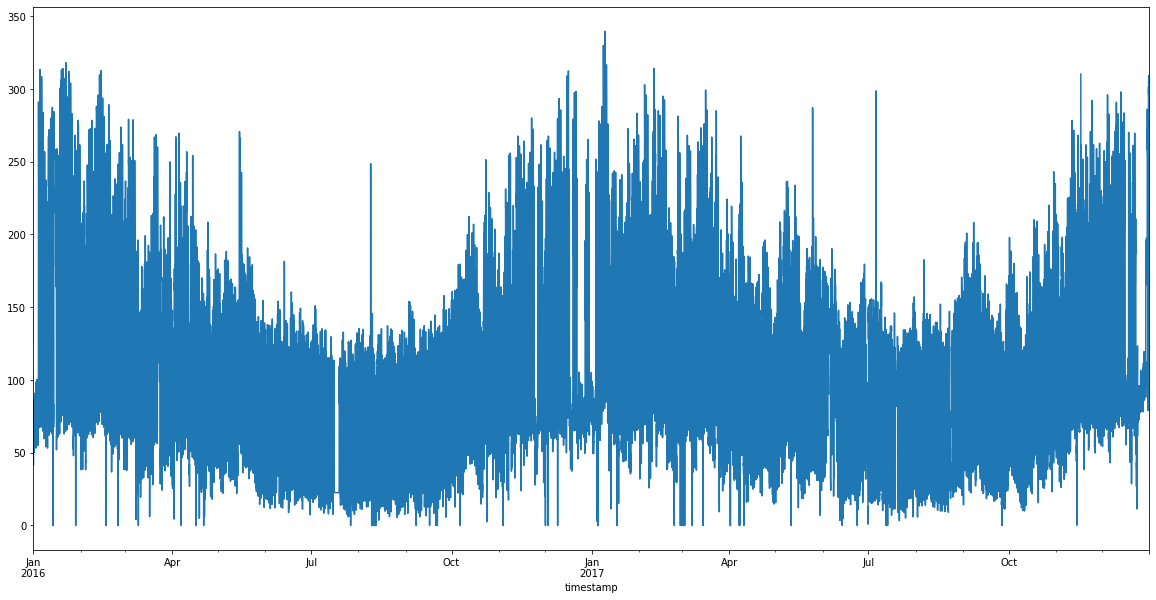

In [6]:
steam_df.plot(figsize=(20,10))

In [7]:
column_means = building. mean()
building = building. fillna(column_means)

## Stationarity Check

In [8]:
#Checking the Stationarity: series that has a constant mean

#Perform Building Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n the test statistic is less than critical value, reject the null hypothesis')
dftest = adfuller(building, autolag = 'AIC') #AIC gives the information about time series 

dfoutput= pd.Series (dftest[0:4], index= ['Test Statistic','p-value: \n p-value is smaller than 0.05','#lags used', 'Number of Observations Used'])
for key, value in dftest [4].items ():
    dfoutput ['Critical Value (%s)' %key] = value

print (dfoutput)

Results of Dickey-Fuller Test: 
 the test statistic is less than critical value, reject the null hypothesis
Test Statistic                             -8.011371e+00
p-value: \n p-value is smaller than 0.05    2.196815e-12
#lags used                                  4.400000e+01
Number of Observations Used                 1.749900e+04
Critical Value (1%)                        -3.430724e+00
Critical Value (5%)                        -2.861705e+00
Critical Value (10%)                       -2.566858e+00
dtype: float64


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

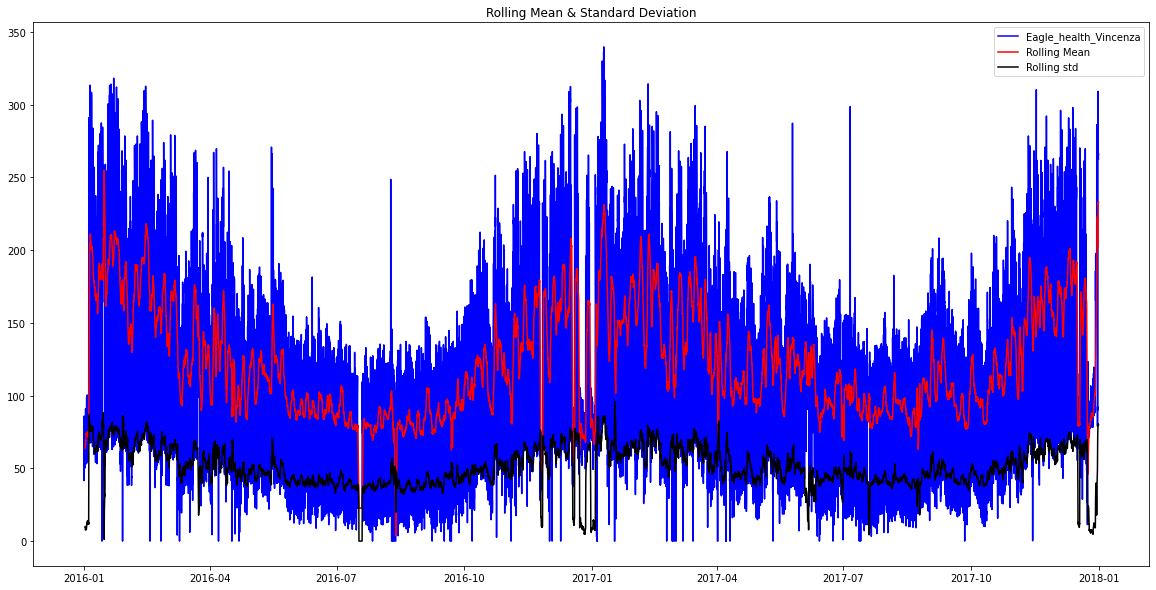

In [9]:

#Determine the rolling statistic
rolmean = building.rolling(window = 24).mean()
rolstd = building.rolling(window = 24).std()

#Checking the Stationarity
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot (building, color = 'blue',label = 'Eagle_health_Vincenza')
mean = plt.plot (rolmean, color = 'red',label = 'Rolling Mean')
std = plt.plot (rolstd, color = 'black',label = 'Rolling std')
plt.legend (loc ='best')
plt.title ('Rolling Mean & Standard Deviation')
#plt.show (block = False)


In [ ]:
#Automatic Time Series Decomposition

decomposition = seasonal_decompose (building.values,period = 24*30, model = 'additive') 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (20,10))
fig = plt.figure(1)


plt.subplot (411)
plt.plot (building, label = 'Building Electricity')
plt.legend(loc ='best')

plt.subplot (412)
plt.plot (trend,label = 'Cyclical')
plt.legend(loc ='best')

plt.subplot (413)
plt.plot (seasonal, label = 'Seasonality')
plt.legend(loc ='best')

plt.subplot (414)
plt.plot (residual, label = 'Residual')
plt.legend(loc ='best')

plt.tight_layout()

print('The result:')
print(decomposition.observed)
print(decomposition.trend)
print(decomposition.seasonal)
print(decomposition.resid)


The result:
[ 45.81  61.84  73.58 ... 265.46 266.37 262.53]
[nan nan nan ... nan nan nan]
[17.31 22.36 26.15 ... 17.2  24.17 33.9 ]
[nan nan nan ... nan nan nan]


## Determine the order of AR, I and MA component 
Using AFC autocorreclation plot and PACF partial autocorrelatioin plot

In [ ]:
fig = plt.figure(figsize = (20,6))
building_acf = fig.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf (building.dropna(),lags = 40, ax = building_acf )
building_pacf = fig.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf (building.dropna(),lags = 40, ax = building_pacf )

In [ ]:
#Determine the arima order using the autorima
#pdq_order = auto_arima(building, trace = True)
#pdq_order.summary()

## ARIMA
AR = p = period for autoregressive model (regression the past lag value, PACF method),
<br>
Integrated = d = order of autoregression (differenced value from present and previous to eliminate the effects of seasonality; removing the trend and seasonality to make it stationary)
<br>
MA = q = periods in moving average (present value is not only depended on the past value but the error lag value as well, use the ACF method)

In [ ]:
size = int(len(building) * 0.5)
train, test = building[0:size], building[size:len(building)]


In [ ]:
test

In [ ]:

train_building = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(train_building, order=(3,0,5))
    results_ARIMA = model.fit()
    output = results_ARIMA.forecast()
    Pred_value = output[0]
    predictions.append(Pred_value)
    obs = test[t]
    train_building.append(obs)
    print('predicted=%f, expected=%f' % (Pred_value, obs))


In [ ]:
#predictions.plot(figsize = (20,6), legend = True)
#test.plot(figsize = (20,6), legend = True)
#plt.show()

## Residuals

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(figsize = (15,6))
plt.show()
# summary stats of residuals
print(residuals.describe())

print (residuals)
results = residuals.to_csv('residuals_steam.csv')

## Evaluate prediction

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes